In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
print (cv2.__version__)

import glob,sys, copy, os
import matplotlib.pyplot as plt

from IPython.display import clear_output

#local calibration utility functions
import calib_utils





3.4.3


In [2]:
#CAMERA NAME GOES HERE
CAMERA_NAME = "axis_10_102_111_112"

#BOARD PARAMETERS GO HERE
target_shape = (17,12)
target_square_size = 0.0497

NPoints_per_board = target_shape[0] * target_shape[1]
target_type = 'chessboard'


In [3]:
#DATA DIRECTORY
CALIB_DATA_DIR = "data/" +  CAMERA_NAME
fnames = sorted(glob.glob(CALIB_DATA_DIR+'/*.jpg')) 

print ("Found {} calibration image files!".format(len(fnames)))


#CALIBRATION FLAGS GO HERE
intrinsic_flags = cv2.CALIB_RATIONAL_MODEL # + cv2.CALIB_ZERO_TANGENT_DIST
intrinsic_term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 1000, 1e-6)   


Found 21 calibration image files!


In [4]:
target_points, target_center = calib_utils.calcChessboardCorners (target_shape, target_square_size, target_type) 
target_points = np.array (target_points, dtype=np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
target_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

num_processed = 0

last_centers = None
for fname in fnames:           
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    [ret_val, centers] = cv2.findChessboardCorners(gray, target_shape, flags=target_flags)
    num_processed += 1
    
   
            
    if (ret_val):
        if (len(np.ravel(centers)) != NPoints_per_board * 2):
            continue

        if(last_centers is not None):
            diff = np.linalg.norm(np.ravel(last_centers) - np.ravel(centers))
            if (diff < 10):
                print ("Too similar ({}), skipping!".format (diff))
                continue
            
        cv2.cornerSubPix(gray, centers, (3,3), (-1,-1), criteria)
        imgpoints.append(centers.reshape(-1,2))
        objpoints.append (target_points)
        #ret = cv2.drawChessboardCorners(img, target_shape, centers,True)
        #cv2.imwrite('USING_'+fname.split('/')[-1],img)

        last_centers = centers

            
    print ("Found in img: {:.2f}%".format(100.0*len(objpoints)/num_processed))
    #print ('{0:.2f}% Complete'.format(100.0*num_processed/len(fnames_left)))
    sys.stdout.flush()
    
   
print ("Found in img: {}".format(len(objpoints)))



Found in img: 100.00%
Found in img: 100.00%
Too similar (1.060774326324463), skipping!
Found in img: 75.00%
Found in img: 80.00%
Found in img: 83.33%
Too similar (1.2899842262268066), skipping!
Found in img: 75.00%
Found in img: 77.78%
Found in img: 80.00%
Found in img: 81.82%
Too similar (3.411820411682129), skipping!
Found in img: 76.92%
Too similar (1.049201250076294), skipping!
Found in img: 73.33%
Found in img: 75.00%
Found in img: 76.47%
Too similar (1.1892837285995483), skipping!
Found in img: 73.68%
Found in img: 75.00%
Found in img: 76.19%
Found in img: 16


In [5]:
print ("Found board in in " , len(objpoints), " images")

err, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None,flags=intrinsic_flags,criteria=intrinsic_term_crit)
distCoeffs = np.squeeze(np.ravel(distCoeffs))[0:8]

print ("RMS error= {}".format(err))
print ("Dist = {}".format(distCoeffs))



Found board in in  16  images
RMS error= 4.966157493406929
Dist = [-4.74750603e+01  7.28203155e+02  1.54133331e-02 -1.72184844e-01
  8.27347394e+02 -4.84910463e+01  8.25205195e+02 -7.69473425e+02]


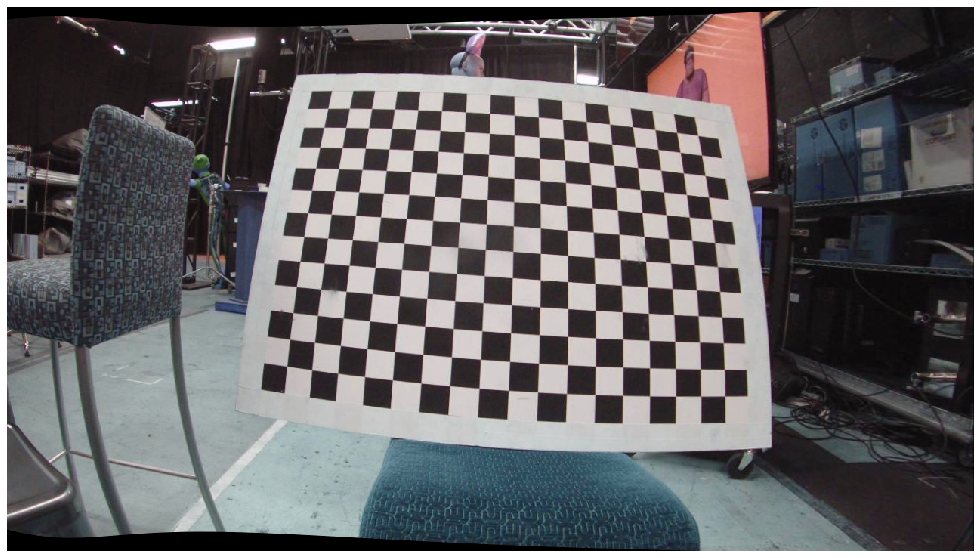

In [6]:
img = cv2.imread(fnames[0])

h, w = img.shape[:2]
ncm, _ = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, (w, h), 0.5, (w, h))

ProjMat = np.zeros((3,4))
for j in range(3):
    for i in range(3):
        ProjMat[j,i] = ncm[j, i]
RectMat = np.eye((3))
dst = cv2.undistort(img, cameraMatrix, distCoeffs, None, ncm)


fig = plt.figure (figsize=(20,10))
fig = plt.imshow(dst,interpolation='nearest')
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [10]:

print("Intrinsic:\n", cameraMatrix,'\n')

print("Distortion:\n", distCoeffs,'\n')

print("Rectification:\n", RectMat,'\n')

print("Projection:\n", ProjMat,'\n')

from MultiCameraCalibrator import CameraCalibrationInfo
        
camera_calibration_left = CameraCalibrationInfo()
camera_calibration_left.height = gray.shape[0]
camera_calibration_left.width = gray.shape[1]
camera_calibration_left.camera_matrix = cameraMatrix
camera_calibration_left.distortion_coefficients = distCoeffs
camera_calibration_left.rectification_matrix = RectMat
camera_calibration_left.projection_matrix = ProjMat

calib_utils.write_camera_info_yaml(camera_calibration_left,CAMERA_NAME, os.path.join('output',CAMERA_NAME+ '.yaml'))

Intrinsic:
 [[3.49120187e+03 0.00000000e+00 7.40625736e+02]
 [0.00000000e+00 1.65366319e+04 3.06875824e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Distortion:
 [-4.74750603e+01  7.28203155e+02  1.54133331e-02 -1.72184844e-01
  8.27347394e+02 -4.84910463e+01  8.25205195e+02 -7.69473425e+02] 

Rectification:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Projection:
 [[3.37129431e+03 0.00000000e+00 6.68404199e+02 0.00000000e+00]
 [0.00000000e+00 1.59671709e+04 3.14298484e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]] 

image_width: 1280
image_height: 720
camera_name: axis_10_102_111_112
camera_matrix:
  rows: 3
  cols: 3
  data: [3491.2018670505977, 0.0, 740.625736440734, 0.0, 16536.63193678229, 306.87582386705907, 0.0, 0.0, 1.0]
distortion_model: rational_polynomial
distortion_coefficients:
  rows: 1
  cols: 8
  data: [-47.47506033157893, 728.2031553733616, 0.015413333132572654, -0.17218484383443972, 827.34739378114, -48.49104626196344, 825.2051